In [1]:
# import
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy import stats

In [2]:
# Read API
API_KEY = ''

with open('ALPHAVANTAGE_API_KEY') as f:
    API_KEY = f.read()

In [3]:
ts = TimeSeries(API_KEY, output_format='pandas', indexing_type='integer') 
ti = TechIndicators(key=API_KEY, output_format='pandas')

In [4]:
# get the data
def getDailyData(ticker):
    priceData, metaData = ts.get_daily(ticker, outputsize='full')
    return priceData, metaData

In [30]:
def preprocess_data(data):
    if 'index' in data.columns:
        data['date'] = pd.to_datetime(data['index'])
        
    # Select the relevant columns for the strategies
    processed_data = data[['date', '1. open', '2. high', '3. low', '4. close', '5. volume']]

    processed_data = processed_data.iloc[::-1].reset_index(drop=True)

    # Ensure the 'date' column is the index if it's available
    # data has index column containing date
    
    processed_data.set_index('date', inplace=True)
    
    # Drop rows with missing values or handle them appropriately
    processed_data = processed_data.dropna()
    
    return processed_data

In [6]:
# Function to calculate Exponential Moving Average (EMA)
def exponential_moving_average(prices, window):
    return prices.ewm(span=window, adjust=False).mean()

# Modified moving average crossover strategy using EMA
def ema_strategy(prices, short_window=5, long_window=20):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    
    # Calculate the Exponential Moving Averages for short and long windows
    signals['short_ema'] = exponential_moving_average(prices, short_window)
    signals['long_ema'] = exponential_moving_average(prices, long_window)

    
    # Generate the signals: 1 when short EMA crosses above long EMA, -1 when it crosses below
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['short_ema'][short_window:] 
                                                > signals['long_ema'][short_window:], 1.0, -1.0)
    
    # Generate trading positions based on signal changes
    signals['positions'] = signals['signal'].diff()
    
    return signals

In [7]:
# Function to calculate the MACD line, Signal line, and MACD Histogram
def macd_strategy(prices, short_window=5, long_window=20, signal_window=5):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices

    # Calculate the Short-Term and Long-Term EMAs
    signals['short_ema'] = prices.ewm(span=short_window, adjust=False).mean()
    signals['long_ema'] = prices.ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD Line (difference between Short-Term and Long-Term EMA)
    signals['macd_line'] = signals['short_ema'] - signals['long_ema']

    # Calculate the Signal Line (9-period EMA of the MACD Line)
    signals['signal_line'] = signals['macd_line'].ewm(span=signal_window, adjust=False).mean()

    # Calculate the MACD Histogram (difference between MACD Line and Signal Line)
    signals['macd_histogram'] = signals['macd_line'] - signals['signal_line']

    # Generate buy/sell signals based on crossovers of MACD Line and Signal Line
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['macd_line'][short_window:] > signals['signal_line'][short_window:], 1.0, -1.0)
    
    # Generate trading positions (1: Buy, -1: Sell, 0: Hold)
    signals['positions'] = signals['signal'].diff()

    signals = signals.dropna()

    return signals

In [8]:
# Define refined MACD strategy function
def refined_macd_strategy(prices, short_window=5, long_window=20, signal_window=5, filter_window=9):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices

    # Calculate the Short-Term and Long-Term EMAs
    signals['short_ema'] = prices.ewm(span=short_window, adjust=False).mean()
    signals['long_ema'] = prices.ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD Line and Signal Line
    signals['macd_line'] = signals['short_ema'] - signals['long_ema']
    signals['signal_line'] = signals['macd_line'].ewm(span=signal_window, adjust=False).mean()
    signals['macd_histogram'] = signals['macd_line'] - signals['signal_line']

    # Calculate an additional moving average for filtering
    signals['filter_ma'] = prices.rolling(window=filter_window, min_periods=1).mean()

    # Generate buy/sell signals based on crossovers of MACD Line and Signal Line, and price confirmation
    signals['signal'] = 0.0
    buy_signals = (signals['macd_line'] > signals['signal_line']) & (prices > signals['filter_ma'])
    sell_signals = (signals['macd_line'] < signals['signal_line']) & (prices < signals['filter_ma'])
    
    signals['signal'][buy_signals] = 1.0
    signals['signal'][sell_signals] = -1.0
    signals['positions'] = signals['signal'].diff()

    signals = signals.dropna()
    
    return signals

In [125]:
# Define backtest function
def backtest_strategy(signals, initial_capital=10000, num_of_backdays=250):    
    # Initialize the portfolio
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['holdings'] = 0.0 # dollar amount in stocks
    portfolio['cash'] = initial_capital # cash left after each trade
    portfolio['total'] = 0 # holding + cash
    portfolio['positions'] = 0 # number of shares in hold
    portfolio['returns'] = 0.0 # each day change in total
    total_num_trading = 0
    total_holding_period = 0
    trades = {"buy date":[], "buy quantity":[], "buy price":[],  "sell price":[],  "sell quantity":[], "sell date":[], "return":[]}

    # Iterate over the signals to simulate trades
    # since it is closing price, will trade at closing time 
    for i in range(len(signals)-num_of_backdays, len(signals)):
        available_cash = portfolio['cash'].iloc[i-1]
        price = signals['price'].iloc[i]
        existing_position = portfolio['positions'].iloc[i-1]
        if signals['signal'].iloc[i] == 1:
            # Buy Signal
            available_position = available_cash // price
            if (available_position > 0):
                portfolio['positions'].iloc[i] = available_position
                portfolio['cash'].iloc[i] = available_cash - (available_position*price)
                trades["buy date"].append(portfolio.index[i])
                trades["buy quantity"].append(portfolio['positions'].iloc[i])
                trades["buy price"].append(signals['price'].iloc[i])
    
                trades["sell date"].append(portfolio.index[i])
                trades["sell quantity"].append(0)
                trades["sell price"].append(0)
                trades["return"].append(0)
        elif (signals['signal'].iloc[i] == -1 and existing_position > 0):
            # Sell Signal
            portfolio['cash'].iloc[i] = available_cash + (existing_position * price)
            portfolio['positions'].iloc[i] = 0
            total_num_trading += 1
            total_holding_period += 1

            trades["sell date"][-1] = portfolio.index[i]
            trades["sell quantity"][-1] = portfolio['positions'].iloc[i-1]
            trades["sell price"][-1] = signals['price'].iloc[i]
            trades["return"][-1] = (trades["sell price"][-1] - trades["buy price"][-1])*portfolio['positions'].iloc[i-1]
        else:
            portfolio['cash'].iloc[i] = available_cash
            portfolio['positions'].iloc[i] = existing_position
            if portfolio['positions'].iloc[i] != 0:
                total_holding_period += 1
        
        # Calculate holdings and total portfolio value
        portfolio['holdings'].iloc[i] = existing_position * price
        portfolio['total'].iloc[i] = portfolio['holdings'].iloc[i] + available_cash

        # Calculate returns
        portfolio['returns'].iloc[i] = (portfolio['total'].iloc[i] - portfolio['total'].iloc[i-1])
    
    return portfolio, {"trades": pd.DataFrame.from_dict(trades), "total_trading":total_num_trading, "avg_holding_period": total_holding_period/total_num_trading, 
                      "OOM days": sum(portfolio["positions"] == 0) - (len(signals)-num_of_backdays), 
                      "total_gain":(portfolio['total'].iloc[-1] - initial_capital)/initial_capital}


In [83]:
# preprocess the data
data, dm = getDailyData('META')
data.shape

(3095, 6)

In [122]:
processed_data = preprocess_data(data)
processed_data.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2012-05-18,42.05,45.00,38.00,38.2318,573576400.0
2012-05-21,36.53,36.66,33.00,34.0300,168192700.0
2012-05-22,32.61,33.59,30.94,31.0000,101786600.0
2012-05-23,31.37,32.50,31.36,32.0000,73600000.0
2012-05-24,32.95,33.21,31.77,33.0300,50237200.0


In [126]:
prices = processed_data['4. close']
prices.head()

date
2012-05-18    38.2318
2012-05-21    34.0300
2012-05-22    31.0000
2012-05-23    32.0000
2012-05-24    33.0300
Name: 4. close, dtype: float64

In [127]:
macd_signals = macd_strategy(prices)
macd_portfolio, info1 = backtest_strategy(macd_signals)

In [47]:
refined_macd_signals = refined_macd_strategy(prices)
refined_macd_portfolio, info2 = backtest_strategy(refined_macd_signals)

In [120]:
info1["trades"]["return"].sum()

-1971.2300000000005

In [128]:
macd_portfolio.tail()

,holdings,cash,total,positions,returns
date,,,,,
2024-08-30,0.0,10000.0,10000.0,0,0.0
2024-09-03,0.0,10000.0,10000.0,0,0.0
2024-09-04,0.0,10000.0,10000.0,0,0.0
2024-09-05,0.0,10000.0,10000.0,0,0.0
2024-09-06,0.0,10000.0,10000.0,0,0.0


1

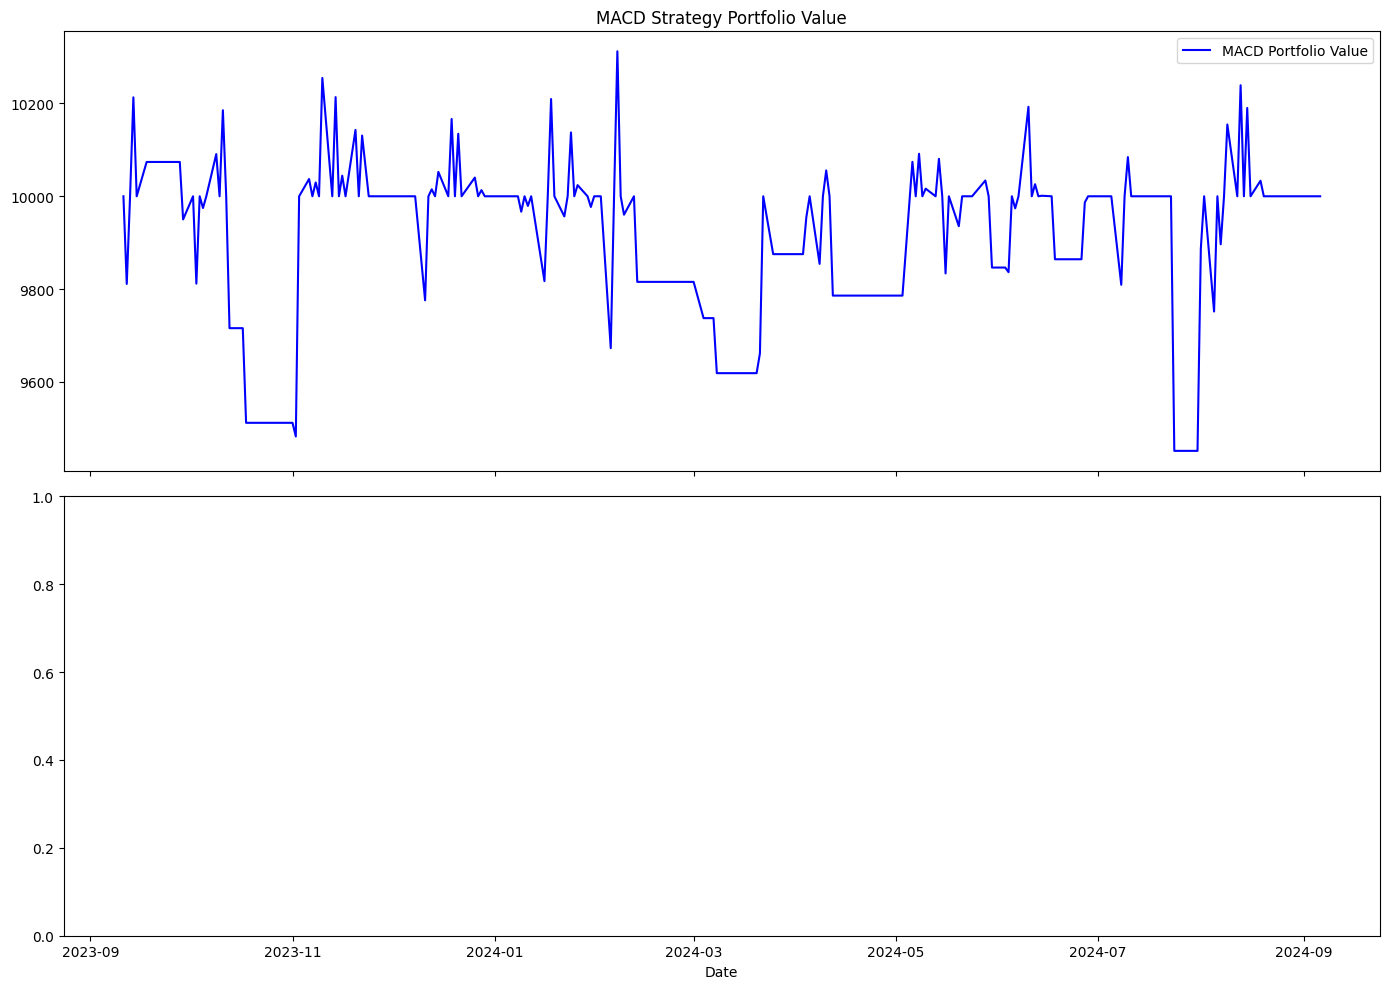

In [130]:
# Plot results
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot MACD Portfolio
ax[0].plot(macd_portfolio.index[-250:], macd_portfolio['total'][-250:], label='MACD Portfolio Value', color='blue')
ax[0].set_title('MACD Strategy Portfolio Value')
ax[0].legend(loc='best')

# # Plot EMA Crossover Portfolio
# ax[1].plot(refined_macd_portfolio.index, refined_macd_portfolio['total'], label='EMA Crossover Portfolio Value', color='green')
# ax[1].set_title('Refine MACD Crossover Strategy Portfolio Value')
# ax[1].legend(loc='best')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

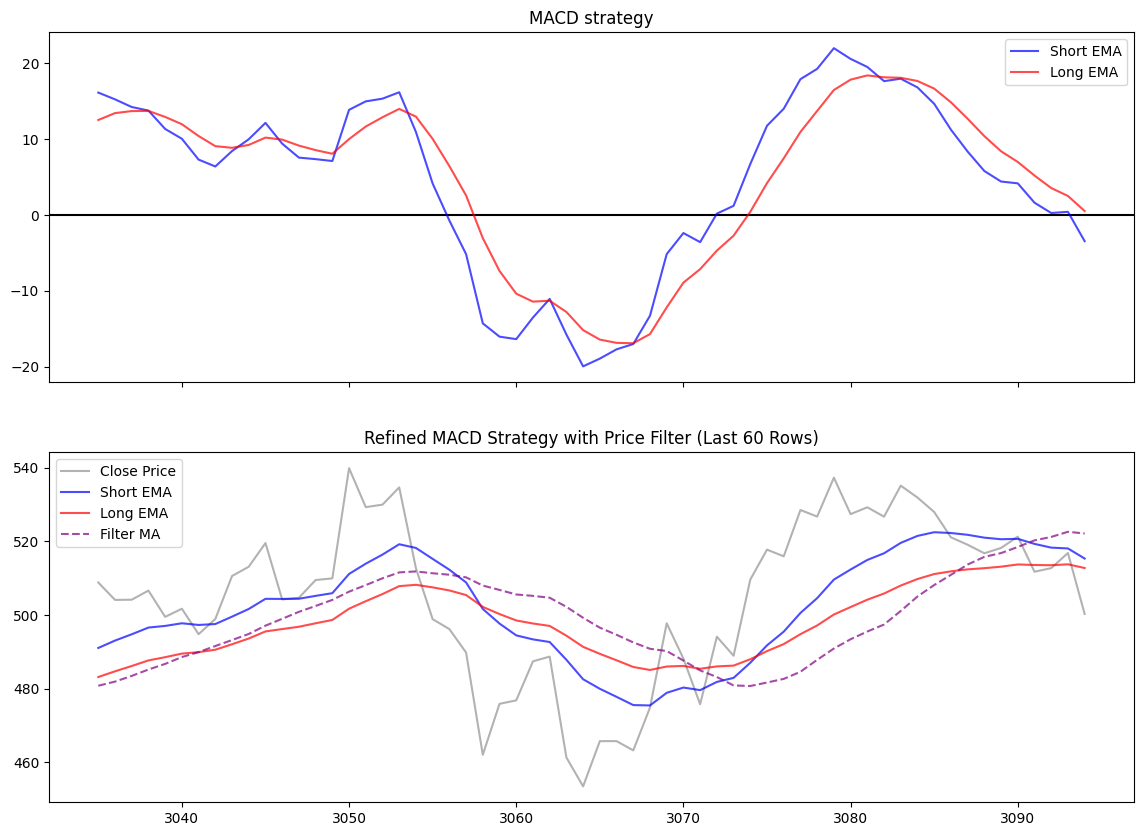

In [89]:
# Plot MACD and EMA
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax[0].axhline(y=0, color='black')
ax[0].plot(last_60_macd.index, last_60_macd['macd_line'], label='Short EMA', color='blue', alpha=0.7)
ax[0].plot(last_60_macd.index, last_60_macd['signal_line'], label='Long EMA', color='red', alpha=0.7)
ax[0].set_title('MACD strategy')
ax[0].legend(loc='best')


ax[1].plot(last_60_refined_macd.index, last_60_refined_macd['price'], label='Close Price', color='black', alpha=0.3)
ax[1].plot(last_60_refined_macd.index, last_60_refined_macd['short_ema'], label='Short EMA', color='blue', alpha=0.7)
ax[1].plot(last_60_refined_macd.index, last_60_refined_macd['long_ema'], label='Long EMA', color='red', alpha=0.7)
ax[1].plot(last_60_refined_macd.index, last_60_refined_macd['filter_ma'], label='Filter MA', color='purple', linestyle='--', alpha=0.7)
ax[1].set_title('Refined MACD Strategy with Price Filter (Last 60 Rows)')
ax[1].legend(loc='best')


<Axes: >

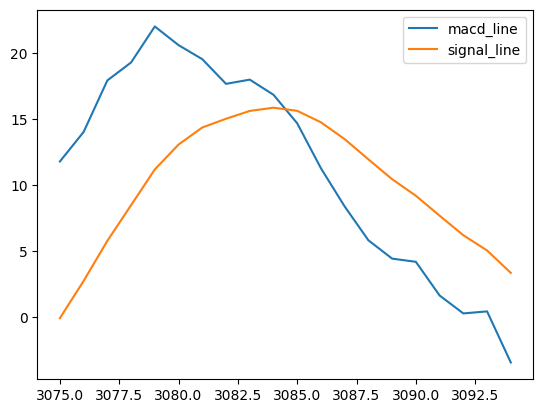

In [53]:
macd = macd_strategy(prices)
macd.tail(20).plot(y = ['macd_line', 'signal_line'])

In [8]:
def mean_reversion_strategy(prices, window=20, num_std_dev=2):
    signals = pd.DataFrame(index=prices.index)
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    signals['upper_band'] = rolling_mean + (rolling_std * num_std_dev)
    signals['lower_band'] = rolling_mean - (rolling_std * num_std_dev)
    signals['signal'] = np.where(prices < signals['lower_band'], 1.0, 
                                 np.where(prices > signals['upper_band'], -1.0, 0.0))
    return signals['signal']

In [9]:
# Combining strategies using majority voting

def majority_voting_strategy(prices):
    # Get individual strategy signals
    ma_signal = moving_average_crossover_strategy(prices)
    rsi_signal = rsi_strategy(prices)
    mean_rev_signal = mean_reversion_strategy(prices)
    
    # Combine signals into a DataFrame
    combined_signals = pd.DataFrame({
        'ma_signal': ma_signal,
        'rsi_signal': rsi_signal,
        'mean_rev_signal': mean_rev_signal
    })
    
    # Majority voting: Sum of signals from each strategy
    combined_signals['final_signal'] = combined_signals[['ma_signal', 'rsi_signal', 'mean_rev_signal']].sum(axis=1)
    
    # Final signal: 1 if majority says buy, -1 if majority says sell, 0 if no consensus
    combined_signals['final_signal'] = np.where(combined_signals['final_signal'] > 0, 1.0, 
                                                np.where(combined_signals['final_signal'] < 0, -1.0, 0.0))
    
    return combined_signals['final_signal']

In [7]:
def rsi_strategy(prices, rsi_window=14):
    signals = pd.DataFrame(index=prices.index)
    signals['rsi'] = calculate_rsi(prices, rsi_window)
    signals['signal'] = np.where(signals['rsi'] < 30, 1.0, np.where(signals['rsi'] > 70, -1.0, 0.0))
    return signals['signal']

In [6]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi